In [6]:
# 파이썬 ≥3.5 필수
import sys
assert sys.version_info >= (3, 5)

# 코랩에서 실행되는 노트북인가요?
IS_COLAB = "google.colab" in sys.modules

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 텐서플로 ≥2.0 필수
import tensorflow as tf
from tensorflow import keras
assert tf.__version__ >= "2.0"

if not tf.config.list_physical_devices('GPU'):
    print("감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.")
    if IS_COLAB:
        print("런타임 > 런타임 유형 변경 메뉴를 선택하고 하드웨어 가속기로 GPU를 고르세요.")

# 공통 모듈 임포트
import numpy as np
import os
from pathlib import Path

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)
tf.random.set_seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "rnn"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("그림 저장", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

감지된 GPU가 없습니다. GPU가 없으면 LSTM과 CNN이 매우 느릴 수 있습니다.


# 15.1 순환 뉴런과 순환 층
- 시간에 따라 네트워크를 펼쳤다 ~ unrolling the network through time
    - 실제로 펼치진 않음. 그냥 그렇게 보는게 편하니까.
- 각 time step의 입력은 그 time step의 입력 데이터와 이전 time step의 출력이 된다.

## 15.1.1 메모리 셀
- time step t에서의 출력은 이전 time step의 모든 입력에 대한 함수이므로, t기의 출력을 '메모리'형태 라고 할 수 있다.
--- 
## 15.1.2 입력과 출력 시퀀스
- seq2seq 네트워크 ~ 시계열 데이터를 예측하는데 유용.
- seq2vec 네트워크 ~ 입력 시퀀스를 네트워크에 주입하고 마지막을 제외한 모든 출력을 무시(**인코더**)
- vec2seq 네크워크 ~ 각 time step에서 하나의 입력 벡터를 반복해서 네트워크에 주입하고 하나의 시퀀스를 출력.(**디코더**)
- **인코더** + **디코더**
    - ex) 번역 
        - 어떤 언어의 문장이 인코더를 통해 하나의 벡터 표현으로 변환되고 벡터가 디코더를 통과하여 다른 언어로 디코딩된다. 

# 15.2 RNN 훈련하기
- **BPTT**: backpropagation through timestep
    - 각 times step에서 마다 비용함수가 계산된다.
    - 모든 step의 비용함수 값을 사용하지 않고 몇 개의 출력을 무시하여 비용함수의 그라디언트를 계산한다. => 가중치 갱신
    - 모든 time step에는 **같은 가중치가 적용된다.**
        - 즉, forward계산 시 모두 동일한 가중치 적용.

# 15.3 시계열 예측하기
- time series(시계열): time step마다 하나 이상의 값을 가진 시퀀스
    - univariate time series(단변량 시계열): time step마다 하나의 값
        <br><br>
    - multivariate time series(다변량 시계열): time step마다 2개 이상의 값
        - ex) 재정안정성(다변량) -> 변량들: 회사의 수입, 부채, 현재 자본 등,,
- forecasting(예측): 미래의 값을 예측하는 작업
- imputation(값 대체): 과거 데이터에서 누락된 값을 예측


In [7]:
#데이터셋 생성
def generate_time_series(batch_size, n_steps):
    freq1, freq2, offsets1, offsets2 = np.random.rand(4, batch_size, 1)
                #4개의 channel ~ 각각 freq1, freq2, offsets1, offsets2 에 할당
                    #freq1 ~ offsets2의 shape:(batch_size, 1)
    time = np.linspace(0, 1, n_steps) #0에서 1까지 n_steps의 간격으로
                #np.linspace(start, stop, num)
    series = 0.5 * np.sin((time - offsets1) * (freq1 * 10 + 10))  #   웨이브 1
    series += 0.2 * np.sin((time - offsets2) * (freq2 * 20 + 20)) # + 웨이브 2
    series += 0.1 * (np.random.rand(batch_size, n_steps) - 0.5)   # + 잡음
    return series[..., np.newaxis].astype(np.float32)

In [8]:
np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 1)


#훈련세트
X_train, y_train = series[:7000, :n_steps], series[:7000, -1]
X_valid, y_valid = series[7000:9000, :n_steps], series[7000:9000, -1]
X_test, y_test = series[9000:, :n_steps], series[9000:, -1]

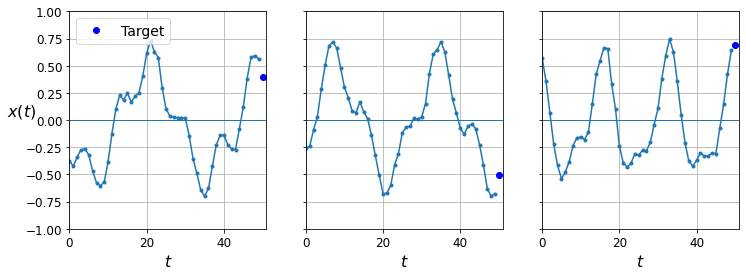

In [9]:
def plot_series(series, y=None, y_pred=None, x_label="$t$", y_label="$x(t)$", legend=True):
    plt.plot(series, ".-")
    if y is not None:
        plt.plot(n_steps, y, "bo", label="Target")
    if y_pred is not None:
        plt.plot(n_steps, y_pred, "rx", markersize=10, label="Prediction")
    plt.grid(True)
    if x_label:
        plt.xlabel(x_label, fontsize=16)
    if y_label:
        plt.ylabel(y_label, fontsize=16, rotation=0)
    plt.hlines(0, 0, 100, linewidth=1)
    plt.axis([0, n_steps + 1, -1, 1])
    if legend and (y or y_pred):
        plt.legend(fontsize=14, loc="upper left")

fig, axes = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(12, 4))
for col in range(3):
    plt.sca(axes[col])
    plot_series(X_valid[col, :, 0], y_valid[col, 0],
                y_label=("$x(t)$" if col==0 else None),
                legend=(col == 0))
plt.show()

## 15.3.1 기준 성능
- 기준 성능을 마련하여 이것을 기준으로 모델의 성능을 판단하자.
    - ex) naive forecasting: 각 시계열의 마지막 값을 그대로 예측

In [10]:
y_pred = X_valid[:, -1]
np.mean(keras.losses.mean_squared_error(y_valid, y_pred))

0.020211367

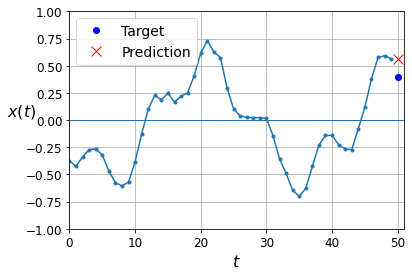

In [11]:
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

- ex) fully connected layer 사용
    - 아래 예시는 완전연결층의 한 종류로, 간단한 선형 회귀 모델 사용

In [12]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Flatten(input_shape=[50, 1]),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 0s 1ms/step - loss: 0.1001 - val_loss: 0.0545
Epoch 2/20
219/219 [==============================] - 0s 640us/step - loss: 0.0379 - val_loss: 0.0266
Epoch 3/20
219/219 [==============================] - 0s 633us/step - loss: 0.0202 - val_loss: 0.0157
Epoch 4/20
219/219 [==============================] - 0s 638us/step - loss: 0.0131 - val_loss: 0.0116
Epoch 5/20
219/219 [==============================] - 0s 636us/step - loss: 0.0103 - val_loss: 0.0098
Epoch 6/20
219/219 [==============================] - 0s 575us/step - loss: 0.0089 - val_loss: 0.0087
Epoch 7/20
219/219 [==============================] - 0s 575us/step - loss: 0.0080 - val_loss: 0.0079
Epoch 8/20
219/219 [==============================] - 0s 685us/step - loss: 0.0073 - val_loss: 0.0071
Epoch 9/20
219/219 [==============================] - 0s 662us/step - loss: 0.0066 - val_loss: 0.0066
Epoch 10/20
219/219 [==============================] - 0s 602us/step - loss: 0.0061 

In [13]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 427us/step - loss: 0.0042


0.004168087150901556

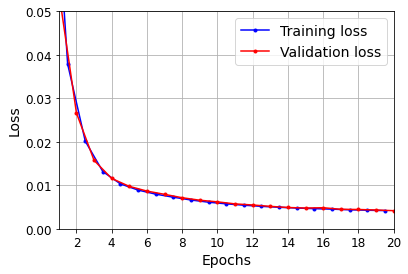

In [14]:
def plot_learning_curves(loss, val_loss):
    plt.plot(np.arange(len(loss)) + 0.5, loss, "b.-", label="Training loss")
    plt.plot(np.arange(len(val_loss)) + 1, val_loss, "r.-", label="Validation loss")
    plt.gca().xaxis.set_major_locator(mpl.ticker.MaxNLocator(integer=True))
    plt.axis([1, 20, 0, 0.05])
    plt.legend(fontsize=14)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.grid(True)

plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

63/63 [==============================] - 0s 484us/step


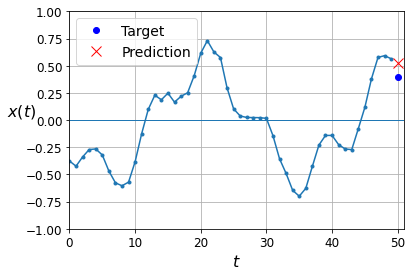

In [15]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()

## 15.3.2 간단한 RNN 구현하기
- 간단한 RNN은 시계열 데이터를 예측하는데 있어서 선형 회귀보다 나을까?

In [16]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(1, input_shape=[None, 1])
])

optimizer = keras.optimizers.Adam(learning_rate=0.005)
model.compile(loss="mse", optimizer=optimizer)
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 1s 4ms/step - loss: 0.0967 - val_loss: 0.0489
Epoch 2/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0369 - val_loss: 0.0296
Epoch 3/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0253 - val_loss: 0.0218
Epoch 4/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0198 - val_loss: 0.0177
Epoch 5/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0166 - val_loss: 0.0151
Epoch 6/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0146 - val_loss: 0.0134
Epoch 7/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0132 - val_loss: 0.0123
Epoch 8/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0124 - val_loss: 0.0116
Epoch 9/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0118 - val_loss: 0.0112
Epoch 10/20
219/219 [==============================] - 1s 3ms/step - loss: 0.0116 - val_loss: 0.0110

In [17]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 1ms/step - loss: 0.0109


0.010881561785936356

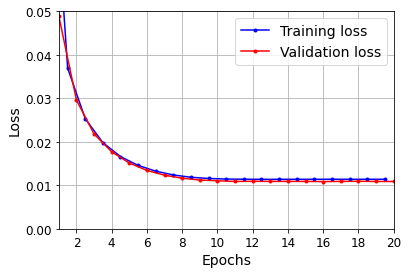

In [18]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()
    #선형 회귀랑 비슷,,?

63/63 [==============================] - 0s 1ms/step


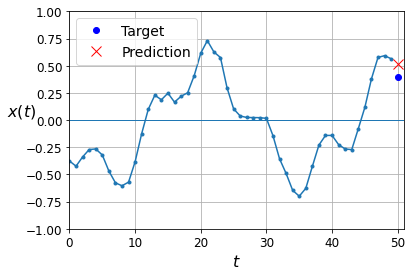

In [19]:
y_pred = model.predict(X_valid)
plot_series(X_valid[0, :, 0], y_valid[0, 0], y_pred[0, 0])
plt.show()
#선형회귀랑 별반 다를게 없어보임

## 15.3.3 심층 RNN
- RNN을 여러 층으로 쌓은 심층 RNN(deep RNN)

In [20]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([ #return_sequences를 False로 하면 마지막 time step에 대한 출력만 나온다
                                #그래서 마지막 time step의 출력만 담은 2D배열이 출력
                                #3D형태로 sequence를 받지 못해서 작동X
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.SimpleRNN(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 9ms/step - loss: 0.0492 - val_loss: 0.0090
Epoch 2/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0070 - val_loss: 0.0065
Epoch 3/20
219/219 [==============================] - 2s 8ms/step - loss: 0.0053 - val_loss: 0.0045
Epoch 4/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0045 - val_loss: 0.0040
Epoch 5/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0042 - val_loss: 0.0040
Epoch 6/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0036
Epoch 7/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0038 - val_loss: 0.0040
Epoch 8/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0037 - val_loss: 0.0033
Epoch 9/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0036 - val_loss: 0.0032
Epoch 10/20
219/219 [==============================] - 2s 9ms/step - loss: 0.0035 - val_loss: 0.0031

In [21]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0029


0.0029105644207447767

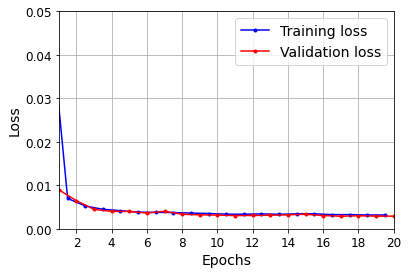

In [22]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show() #simple RNN보다는 훨씬 나은 것 같다

In [23]:
#두번째 RNN층에서 마지막 time step의 출력만 리턴하면 더 성능이 좋음
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20),
    keras.layers.Dense(1)
])

model.compile(loss="mse", optimizer="adam")
history = model.fit(X_train, y_train, epochs=20,
                    validation_data=(X_valid, y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0232 - val_loss: 0.0052
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0043 - val_loss: 0.0036
Epoch 3/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0035 - val_loss: 0.0031
Epoch 4/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 5/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0033 - val_loss: 0.0034
Epoch 6/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0031 - val_loss: 0.0029
Epoch 7/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0031 - val_loss: 0.0034
Epoch 8/20
219/219 [==============================] - 1s 7ms/step - loss: 0.0032 - val_loss: 0.0028
Epoch 9/20
219/219 [==============================] - 2s 7ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 10/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0030 - val_loss: 0.0029

In [24]:
model.evaluate(X_valid, y_valid)

63/63 [==============================] - 0s 2ms/step - loss: 0.0026


0.002623623702675104

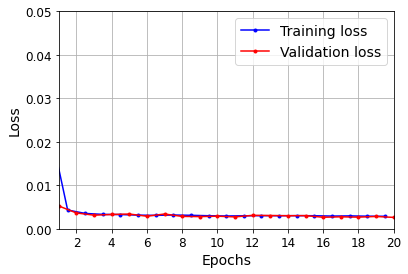

In [25]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show() #훨씬 더 좋아짐

## 15.3.4 여러 타임 스텝 앞을 예측하기
- 다음 10개의 값을 예측하고 싶다면,,?
1. 이미 훈련된 모델을 사용하여 다음 값을 예측한 다음 이 값을 입력으로 추가

In [26]:
series = generate_time_series(1, n_steps + 10)
#새로운 데이터 생성
X_new, Y_new = series[:, :n_steps], series[:, n_steps:]

X = X_new
for step_ahead in range(10):
    y_pred_one = model.predict(X[:, step_ahead:])[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:]

1/1 [==============================] - 0s 12ms/step


In [27]:
Y_pred.shape

(1, 10, 1)

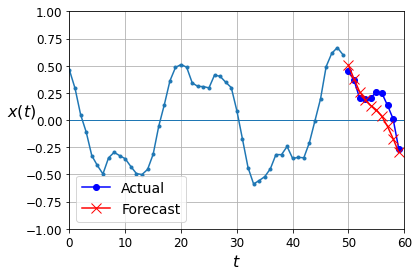

In [28]:
def plot_multiple_forecasts(X, Y, Y_pred):
    n_steps = X.shape[1]
    ahead = Y.shape[1]
    plot_series(X[0, :, 0])
    plt.plot(np.arange(n_steps, n_steps + ahead), Y[0, :, 0], "bo-", label="Actual")
    plt.plot(np.arange(n_steps, n_steps + ahead), Y_pred[0, :, 0], "rx-", label="Forecast", markersize=10)
    plt.axis([0, n_steps + ahead, -1, 1])
    plt.legend(fontsize=14)

plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show()

In [29]:
np.random.seed(42)
#위 모델로 10개의 값 예측

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train, Y_train = series[:7000, :n_steps], series[:7000, -10:, 0]
X_valid, Y_valid = series[7000:9000, :n_steps], series[7000:9000, -10:, 0]
X_test, Y_test = series[9000:, :n_steps], series[9000:, -10:, 0]

In [30]:
#10개의 값을 하나씩 예측하기
X = X_valid
for step_ahead in range(10):
    y_pred_one = model.predict(X)[:, np.newaxis, :]
    X = np.concatenate([X, y_pred_one], axis=1)

Y_pred = X[:, n_steps:, 0]

63/63 [==============================] - 0s 2ms/step


In [31]:
Y_pred.shape

(2000, 10)

In [32]:
np.mean(keras.metrics.mean_squared_error(Y_valid, Y_pred))

0.027510861

In [33]:
#각 time step마다 다음 10개의 step을 예측하는 RNN
    #1 time step 에서는 2~11 예측..
    #2 time step에서는 3~12 예측...
        #casual model이라고도 한다: 과거 time step만을 보고 예측

np.random.seed(42)

n_steps = 50
series = generate_time_series(10000, n_steps + 10)
X_train = series[:7000, :n_steps]
X_valid = series[7000:9000, :n_steps]
X_test = series[9000:, :n_steps]
Y = np.empty((10000, n_steps, 10))
for step_ahead in range(1, 10 + 1):
    Y[..., step_ahead - 1] = series[..., step_ahead:step_ahead + n_steps, 0]
Y_train = Y[:7000]
Y_valid = Y[7000:9000]
Y_test = Y[9000:]

In [34]:
X_train.shape, Y_train.shape

((7000, 50, 1), (7000, 50, 10))

In [35]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.SimpleRNN(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.SimpleRNN(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

def last_time_step_mse(Y_true, Y_pred):
    return keras.metrics.mean_squared_error(Y_true[:, -1], Y_pred[:, -1])

model.compile(loss="mse", optimizer=keras.optimizers.Adam(learning_rate=0.01), metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 3s 7ms/step - loss: 0.0508 - last_time_step_mse: 0.0400 - val_loss: 0.0429 - val_last_time_step_mse: 0.0324
Epoch 2/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0395 - last_time_step_mse: 0.0283 - val_loss: 0.0367 - val_last_time_step_mse: 0.0266
Epoch 3/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0325 - last_time_step_mse: 0.0215 - val_loss: 0.0320 - val_last_time_step_mse: 0.0197
Epoch 4/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0299 - last_time_step_mse: 0.0188 - val_loss: 0.0280 - val_last_time_step_mse: 0.0165
Epoch 5/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0276 - last_time_step_mse: 0.0158 - val_loss: 0.0264 - val_last_time_step_mse: 0.0154
Epoch 6/20
219/219 [==============================] - 1s 6ms/step - loss: 0.0254 - last_time_step_mse: 0.0129 - val_loss: 0.0237 - val_last_time_step_mse: 0.0104
Epoch 7/20
219/219 [========

In [36]:
np.random.seed(43)

series = generate_time_series(1, 50 + 10)
X_new, Y_new = series[:, :50, :], series[:, 50:, :]
Y_pred = model.predict(X_new)[:, -1][..., np.newaxis]

1/1 [==============================] - 0s 176ms/step


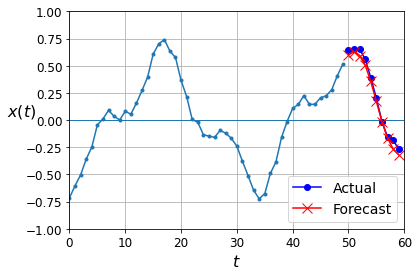

In [37]:
plot_multiple_forecasts(X_new, Y_new, Y_pred)
plt.show() #가장 정확,,,

# 15.4 긴 시퀀스 다루기 
- 긴 시퀀스로 RNN훈련하면 기울기 소실 or 폭주 문제
    - 어떻게 긴 sequence에 대해서 학습할까,,,?

## 15.4.1 불안정한 그레이디언트 문제와 싸우기
- ReLU처럼 수렴하지 않는 활성화 함수는 그라디언트 문제 해결에 도움되지 않는다.
    - 오히려 그라디언트를 더 불안정하게 만들 수 있다.
        - 출력이 증가 -> 계속 증가하여 폭발
    ---
    - 따라서 tanh같은 수렴하는 활성화 함수를 사용 & 그라디언트 클라핑 사용
---
- BN은 RNN과 효율적 사용이 힘들다.
    - [Batch Normalized RNN](https://arxiv.org/pdf/1510.01378v1.pdf)
        - 위 논문에 따르면,
        메모리 셀에 BN층을 추가하여 매 time step마다 BN을 적용하는 것은 좋은 결과를 만들지 못한다. RNN에 BN을 적용하는 것은 은닉 상태가 아니라 입력에 적용했을 때만 도움이 된다. 
---
- RNN에 알맞은 정규화는 layer normalization이다. 
    - 배치 차원에 대해 정규화 하는 대신 특성 차원에 대해 정규화.
    - 장점: 
            샘플에 독립적으로 time step마다 동적으로 필요한 통계 계산
            지수이동 평균이 필요하지 않다.
            BN과 마찬가지로 하나의 스케일과 이동 파라미터를 학습

In [38]:
from tensorflow.keras.layers import LayerNormalization

In [39]:
class LNSimpleRNNCell(keras.layers.Layer):
    def __init__(self, units, activation="tanh", **kwargs):
        super().__init__(**kwargs)
        self.state_size = units
        self.output_size = units
        self.simple_rnn_cell = keras.layers.SimpleRNNCell(units,
                                                          activation=None)
        self.layer_norm = LayerNormalization()
        self.activation = keras.activations.get(activation)
    def get_initial_state(self, inputs=None, batch_size=None, dtype=None):
        if inputs is not None:
            batch_size = tf.shape(inputs)[0]
            dtype = inputs.dtype
        return [tf.zeros([batch_size, self.state_size], dtype=dtype)]
    def call(self, inputs, states):
        outputs, new_states = self.simple_rnn_cell(inputs, states)
        norm_outputs = self.activation(self.layer_norm(outputs))
        return norm_outputs, [norm_outputs]


In [40]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True,
                     input_shape=[None, 1]),
    keras.layers.RNN(LNSimpleRNNCell(20), return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 18ms/step - loss: 0.1622 - last_time_step_mse: 0.1582 - val_loss: 0.0757 - val_last_time_step_mse: 0.0705
Epoch 2/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0665 - last_time_step_mse: 0.0577 - val_loss: 0.0595 - val_last_time_step_mse: 0.0488
Epoch 3/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0561 - last_time_step_mse: 0.0459 - val_loss: 0.0526 - val_last_time_step_mse: 0.0415
Epoch 4/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0497 - last_time_step_mse: 0.0381 - val_loss: 0.0464 - val_last_time_step_mse: 0.0363
Epoch 5/20
219/219 [==============================] - 4s 16ms/step - loss: 0.0446 - last_time_step_mse: 0.0345 - val_loss: 0.0428 - val_last_time_step_mse: 0.0322
Epoch 6/20
219/219 [==============================] - 4s 17ms/step - loss: 0.0410 - last_time_step_mse: 0.0314 - val_loss: 0.0395 - val_last_time_step_mse: 0.0291
Epoch 7/20
219/219 [==

## 15.4.2 단기 기억 문제 해결하기
- LSTM(long-short term memory)
    - keras에서는 ```layers.LSTM```을 사용하면 된다.

In [41]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.LSTM(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.LSTM(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 17ms/step - loss: 0.0760 - last_time_step_mse: 0.0615 - val_loss: 0.0554 - val_last_time_step_mse: 0.0364
Epoch 2/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0480 - last_time_step_mse: 0.0283 - val_loss: 0.0427 - val_last_time_step_mse: 0.0222
Epoch 3/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0391 - last_time_step_mse: 0.0181 - val_loss: 0.0367 - val_last_time_step_mse: 0.0157
Epoch 4/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0350 - last_time_step_mse: 0.0151 - val_loss: 0.0334 - val_last_time_step_mse: 0.0132
Epoch 5/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0325 - last_time_step_mse: 0.0133 - val_loss: 0.0314 - val_last_time_step_mse: 0.0121
Epoch 6/20
219/219 [==============================] - 3s 13ms/step - loss: 0.0308 - last_time_step_mse: 0.0122 - val_loss: 0.0298 - val_last_time_step_mse: 0.0112
Epoch 7/20
219/219 [==

In [42]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0086


[0.023788683116436005, 0.008560797199606895]

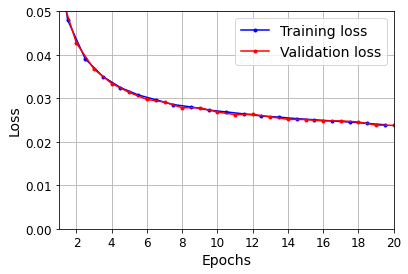

In [43]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 6.1.2 기울기 소실 또는 기울기 폭발

문장이 길어질 때

예를 들어, Tom was watching TV in his room. Mary came into the room. Mary said hi to ___?__.

RNN은 중요한 정보를 ‘기억’해두고 다음 hidden cell로 넘겨줘야한다.(기억 = RNN 계층의 은닉 상태에 encoding하여 보관)

RNN 계층이 과거 방향으로 ‘의미 있는 기울기’를 전달하여 시간 방향의 의존 관계를 학습.

**만약 기울기가 사라져버린다면? ↔ 아무런 정보도 남지 않게 되어버린다면?**

- 가중치가 갱신되지 않을 것이다.
- 단순한 RNN 계층에서는 time step이 길어질수록 vanishing gradient / exploding gradient 문제가 일어나게 된다.

### 기울기 소실과 기울기 폭발의 원인?

RNN의 역전파는 차례대로 tanh, +, Matmul(행렬곱)연산을 통과한다.

1. tanh함수의 미분값
    - $\tanh(x) = {e^x-e^{-x} \over e^x +e^{-x}}$를 $x$에 대하여 미분한다면?
        - 미분 공식 $\{ {f(x)\over g(x)}\}' = {f'(x)g(x)-f(x)g'(x)\over g(x)^2}$을 사용
        - 네이피어 수 $e$에 대한 미분은 ${\partial e^{-x} \over \partial x }= e^x, \space {\partial e^x \over \partial x }= -e^{-x}$로 계산할 수 있다.
            - 위 2개의 식을 활용하여 계산하면 $\tanh'(x) = 1-\tanh (x)^2$을 구할 수 있다.
    - 따라서, tanh’(x)을 계속 계산할수록 미분값이 작아질 수 밖에 없다.
2. ‘+’ ⇒ 그대로 흘려보낸다.
3. Matmul(행렬곱) ⇒ 코드로 확인
    
    ```python
    N = 2 #미니배치 크기
    H = 3 #은닉 상태 벡터의 차원 수
    T = 20 #시계열 데이터의 길이
    
    dh = np.ones((N, H)) #dh: 모든 원소가 1인 2 x 3 행렬
    Wh = np.random.randn(H, H)
    norm_list = []
    for t in range(T):
    	dh = np.matmul(dh, Wh.T)
    	norm = np.sqrt(np.sum(dh**2)) / N #l2 norm을 구하고 N(미니배치 크기)로 나눠줌.
    	norm_list.append(norm)
    ```
    
    ⭐결과적으로 **기울기의 크기는 시간에 비례해 지수적으로(exponentially) 증가(increase)한다.**
    
    ⭐만약 **가중치** 초기값에 0.5를 곱해 **작게 만들면, 기울기의 크기는 시간에 비례해 지수적으로(exponentially) 감소(decrease)한다.**
    
    ① Wh가 스칼라일 경우
    
    - 1보다 크면 **exponentially increase**
    - 1보다 작으면 **exponentially decrease**
    
    ② Wh가 행렬일 경우 
    
    - 행렬의 ‘특잇값’이 척도가 된다.(특잇값 = $\sqrt \lambda_i$)
        - 특잇값의 최댓값이 1보다 크면 **exponentially increase**
        - 특잇값의 최댓값이 1보다 작으면 **exponentially decrease**
        
        반드시 그렇게 된다는 것은 아니고, **그럴 가능성이 높다는 것이다.**
        

### 기울기 폭발 대책 ⇒ gradients clipping

1. Gradients clipping
    1. if $||\hat{\mathbf{g}}||\ge\mathsf{threshold}:\space \space \hat{\mathbf{g}} = {1\over ||\hat{\mathbf{g}}||}\hat{\mathbf{g}}$
2. Drop out

## 기울기 소실과 LSTM

① **Memory cell**($\mathbf{c_t}$): **LSTM 전용의 기억 메커니즘**

- LSTM 계층 내에서만 주고 받고, 다른 계층으로 출력하지 않음.
- $t$기의 기억 셀 $\mathbf{c_t}$에는 과거에서 $t$까지에 필요한 모든 정보가 저장되도록 학습을 수행.
- 3개의 입력 ($\mathbf{c_{t-1}}, \mathbf{h_{t-1}, \mathbf{x_{t}}}$)으로부터 계산을 수행.
    - 어떤 계산?
        - ㅇㄻ

$\mathbf{h_{t}} = \tanh(\mathbf{c_{t}})$ ⇒ 갱신된 $\mathbf{c_{t}}$를 사용하여 은닉상태 $\mathbf{h_{t}}$를 계산한다.

- NOTICE
    
    생각해보면 기억 셀과 은닉 상태의 원소 수가 같을 수 밖에 없다.
    

② **새로운 기억 셀($\mathbf{g_{}}$)**

- 새로 기억해야 할 정보를 기억 셀에 추가한다.
- tanh 노드를 추가(Gate가 아님) ⇒ 새로운 ‘정보’를 기억 셀에 추가

$\mathbf{g} = \sigma(\mathbf{x_{t}}\mathbf{W_{x}}^{(\mathbf{g})}\mathbf{+} \mathbf{h_{t-1}}\mathbf{W_{h}}^{(\mathbf{g})} + \mathbf{b}^{\mathbf{(g)}})$

⇒ 이 $\mathbf{g}$가 $\mathbf{c_{t-1}}$에 더해짐으로써 새로운 기억 셀 $\mathbf{c_{t}}$이 생겨난다.

### LSTM의 Gate

- **tanh와 sigmoid를 사용하는 이유(간단)**
    1. tanh의 출력은 -1.0 ~ 1.0의 실수. ‘정보’의 정도(강약)을 표시. ⇒ 실질적 정보를 지닌 데이터에는 tanh을 사용.
    2. sigmoid의 출력은 0.0 ~ 1.0의 실수. ‘정보’를 얼마만큼 보낼지 결정 ⇒ 게이트에서 사용.

GATE: openess(열림 상태)를 결정한다.

   정보의 흐름을 제어하며 정보가 어느 정도 흐를지 말지 조절할 수 있다.

1. **Output gate**(은닉상태 $\mathbf{h_{t}}$의 **출력**을 담당)
    - $\tanh(\mathbf{c_{t}})$에 게이트를 적용함으로써 $\tanh(\mathbf{c_{t}})$의 각 원소에 대해 ‘그것이 다음 time step의 hidden state에 얼마나 중요한가’를 조정.
    - $\mathbf{o} = \sigma(\mathbf{x_{t}}\mathbf{W_{x}}^{(\mathbf{o})}\mathbf{+} \mathbf{h_{t-1}}\mathbf{W_{h}}^{(\mathbf{o})} + \mathbf{b}^{\mathbf{(o)}})$
        - input: $\mathbf{x_{t}}$, previous hidden state: $\mathbf{h_{t-1}}$ ⇒ **o**를 계산
    
    $\mathbf{h_{t}} = \mathbf{o} \odot \tanh(\mathbf{c_{t}})$ 계산한 **O** 와 tanh(c)를 **아다마르 곱(원소곱)** 하여 $\mathbf{h_{t}}$를 계산.
    
2. **Forget gate**($\mathbf{c_{t}}$에서 불필요한 정보를 삭제)
    - $\mathbf{f} = \sigma(\mathbf{x_{t}}\mathbf{W_{x}}^{(\mathbf{f})}\mathbf{+} \mathbf{h_{t-1}}\mathbf{W_{h}}^{(\mathbf{f})} + \mathbf{b}^{\mathbf{(f)}})$
    
    $\mathbf{c_{t}} = \mathbf{f} \odot \mathbf{c_{t-1}}$을 계산하여 $\mathbf{c_{t}}$를 구할 수 있다. 
    
3. **Input gate(새로 추가되는 정보의 가치를 판단)**
    - $\mathbf{g}$의 각 원소가 새로 추가되는 정보로써의 가치가 얼마나 큰지 판단한다.
        - 새로 들어오는 정보를 모두 고려하는 것이 아닌, 적절히 선택하여 수용.
    
    $\mathbf{i} = \sigma(\mathbf{x_{t}}\mathbf{W_{x}}^{(\mathbf{i})}\mathbf{+} \mathbf{h_{t-1}}\mathbf{W_{h}}^{(\mathbf{i})} + \mathbf{b}^{\mathbf{(i)}})$
    
    ⇒ $\mathbf{i} \odot \mathbf{g}$의 결과를 기억 셀 $\mathbf{c_{t}}$에 추가한다.
    


## LSTM의 기울기 흐름

LSTM은 어떤 원리로 gradient vanishing problem을 막을 수 있을까? ⇒ $\mathbf{c_t}$에 집중해보자


Memory cell($\mathbf{c_t}$) ⇒ 역전파 때 ‘+’와 ‘x’노드만 존재.

1. $+$: 상류의 기울기를 그대로 보냄. gradient에 영향X
2. X : LSTM에서는 행렬곱(matmul)이 아닌 원소별 곱(아다마르 곱)을 사용한다. 
    - RNN의 역전파와 다른점
        - RNN에서는 똑같은 가중치 행렬을 사용하여 ‘행렬 곱’을 반복 ⇒ 기울기 소실이 일어남
        - LSTM에서는 매 시각 다른 게이트 값을 이용해 원소별 곱을 계산 ⇒ 매번 새로운 게이트 값을 이용하므로 곱셈의 효과가 누적되지 않기 때문에 기울기 소실이 일어나기 어렵다.
- ‘X’노드 계산은 **Forget Gate**가 제어.
    - forget gate 값과 직전의 memory cell($\mathbf{c_{t-1}}$)을 곱하여 다음 memory cell($\mathbf{c_t}$)이 만들어 진다.
    - 이 점을 다시 생각해보면
        - forget gate가 작은 값 ⇒ 정보를 작게 보내야함(잊어야 함) ⇒ 기울기가 작아짐
        - forget gate가 큰 값 ⇒ 정보를 많이 보내야함(잊으면 안됨) ⇒ 기울기가 작아지지 않음
    
    결과적으로 memory cell이 장기 의존 관계를 학습할 수 있을 것이다.

### GRU 셀 
- GRU: gated recurrent unit

In [44]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.GRU(20, return_sequences=True, input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))

Epoch 1/20
219/219 [==============================] - 6s 17ms/step - loss: 0.0738 - last_time_step_mse: 0.0655 - val_loss: 0.0538 - val_last_time_step_mse: 0.0450
Epoch 2/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0476 - last_time_step_mse: 0.0367 - val_loss: 0.0441 - val_last_time_step_mse: 0.0326
Epoch 3/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0417 - last_time_step_mse: 0.0301 - val_loss: 0.0390 - val_last_time_step_mse: 0.0275
Epoch 4/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0368 - last_time_step_mse: 0.0243 - val_loss: 0.0339 - val_last_time_step_mse: 0.0202
Epoch 5/20
219/219 [==============================] - 3s 14ms/step - loss: 0.0326 - last_time_step_mse: 0.0180 - val_loss: 0.0312 - val_last_time_step_mse: 0.0164
Epoch 6/20
219/219 [==============================] - 3s 15ms/step - loss: 0.0306 - last_time_step_mse: 0.0155 - val_loss: 0.0294 - val_last_time_step_mse: 0.0143
Epoch 7/20
219/219 [==

In [45]:
model.evaluate(X_valid, Y_valid)

63/63 [==============================] - 0s 3ms/step - loss: 0.0238 - last_time_step_mse: 0.0103


[0.023785505443811417, 0.010262809693813324]

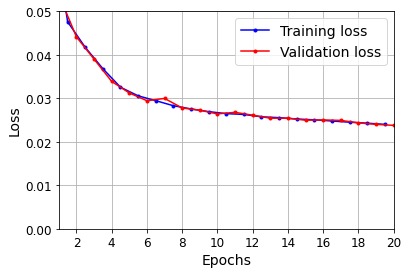

In [46]:
plot_learning_curves(history.history["loss"], history.history["val_loss"])
plt.show()

### 1D 합성곱 층을 사용해 시퀀스 처리하기
- 1D 합성곱 층이 몇 개의 커널을 시퀀스 위로 슬라이딩 -> 커널마다 1D feature map을 출력
    - 각 커널은 매우 짧은 하나의 순차 패턴을 감지
    - 10개의 커널을 사용 -> 출력: 10개의 1차원 시퀀스
    - valid 패딩 & 1보다 큰 stride: 출력 시퀀스가 입력 시퀀스보다 짧아짐 => 생각했던 target의 shape이 맞는지 확인 

In [ ]:
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential([
    keras.layers.Conv1D(filters=20, kernel_size=4, strides=2, padding="valid",
                        input_shape=[None, 1]),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.GRU(20, return_sequences=True),
    keras.layers.TimeDistributed(keras.layers.Dense(10))
])

model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train[:, 3::2], epochs=20,
                    validation_data=(X_valid, Y_valid[:, 3::2]))

### [WaveNet](https://arxiv.org/pdf/1609.03499v2.pdf) 
- 논문: WaveNet: A Generative Model for Raw Audio
    - 첫번째 합성 곱 층은 2개의 time step, 다음 conv 층은 4개의 time stpe => 팽창 비율을 2배로 늘려감
        - 1, 2, 4, 8, 16, 32, 64, 128, 256, 512 이렇게 총 10개의 층을 쌓아 모델 형성. 
        - 이러한 팽창 비율을 가진 CNN -> 1024커널 한개로 이루어진 매우 효율적인 CNN layer처럼 작동.

In [ ]:
#WaveNet 구현
np.random.seed(42)
tf.random.set_seed(42)

model = keras.models.Sequential()
model.add(keras.layers.InputLayer(input_shape=[None, 1]))
for rate in (1, 2, 4, 8) * 2:
    model.add(keras.layers.Conv1D(filters=20, kernel_size=2, padding="causal",
                                  activation="relu", dilation_rate=rate))
model.add(keras.layers.Conv1D(filters=10, kernel_size=1))
model.compile(loss="mse", optimizer="adam", metrics=[last_time_step_mse])
history = model.fit(X_train, Y_train, epochs=20,
                    validation_data=(X_valid, Y_valid))